In [1]:
import torch
import numpy as np
import seaborn as sns

import sys
sys.path.append('..')
import datafree

In [2]:
!nvidia-smi

Thu Mar 10 13:17:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:04:00.0 Off |                  N/A |
| 71%   64C    P2   316W / 350W |  11419MiB / 24268MiB |     88%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:05:00.0 Off |                  N/A |
| 83%   

In [3]:
distributed = False
gpu = 2
batch_size = 256
workers = 8
num_classes = 10
def prepare_model(model):
    if not torch.cuda.is_available():
        print('using CPU, this will be slow')
        return model
    elif distributed:
        # For multiprocessing distributed, DistributedDataParallel constructor
        # should always set the single device scope, otherwise,
        # DistributedDataParallel will use all available devices.
        if args.gpu is not None:
            torch.cuda.set_device(gpu)
            model.cuda(gpu)
            # When using a single GPU per process and per
            # DistributedDataParallel, we need to divide the batch size
            # ourselves based on the total number of GPUs we have
            batch_size = int(batch_size / ngpus_per_node)
            workers = int((workers + ngpus_per_node - 1) / ngpus_per_node)
            model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[gpu])
            return model
        else:
            model.cuda()
            model = torch.nn.parallel.DistributedDataParallel(model)
            return model
    elif gpu is not None:
        torch.cuda.set_device(gpu)
        model = model.cuda(gpu)
        return model
    else:
        # DataParallel will divide and allocate batch_size to all available GPUs
        model = torch.nn.DataParallel(model).cuda()
        return model

In [4]:
from torchvision.datasets import CIFAR10
import registry
student = registry.get_model('resnet18', num_classes=num_classes)
teacher = registry.get_model('resnet34', num_classes=num_classes, pretrained=True).eval()
normalizer = datafree.utils.Normalizer(**registry.NORMALIZE_DICT['cifar10'])
student = prepare_model(student)
teacher = prepare_model(teacher)
teacher.load_state_dict(torch.load('/data/lijingru/DataFree/checkpoints/scratch/cifar10_resnet34.pth', map_location='cpu')['state_dict'])
teacher.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [5]:
def get_losses(t_out, t_feat):
    p = F.softmax(t_out, dim=1).mean(0)
    ent = (p*p.log()).sum()
    loss_oh = F.cross_entropy( t_out, t_out.max(1)[1])
    loss_act = - t_feat.abs().mean()
    return {'neg_ent': ent.item(), 't_conf': loss_oh.item(), 'l_act': loss_act.item()}

In [6]:
import numpy as np
num_classes, ori_dataset, val_dataset = registry.get_dataset(name='cifar10', data_root='/data/lijingru/cifar10/')
random_idx = np.random.randint(0, len(ori_dataset), (256,))

Files already downloaded and verified
Files already downloaded and verified


In [7]:
x_feats = []
outputs = []
real_loader = torch.utils.data.DataLoader(ori_dataset, batch_size=256, shuffle=False, num_workers=workers, pin_memory=True)
for data in real_loader:
    x, y = data
    x = x.to(gpu)
    output, x_feat = teacher(x, return_features=True)
    x_feats.append(x_feat.detach().cpu().numpy())
    outputs.append(output.detach().cpu().numpy())

/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/lijingru/anaconda3/envs/torch/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

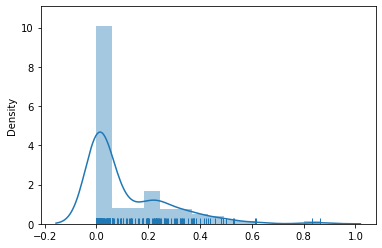

In [8]:
x_feats_all = np.vstack(x_feats)
outputs_all = np.vstack(outputs)

x_feats = x_feats_all[random_idx]
outputs = outputs_all[random_idx]
c_feat = x_feats[:, 15]
sns.distplot(c_feat, rug=True)

In [9]:
G = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, img_size=32, d=2, nc=3)
G = prepare_model(G)
ckpt_path = '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_reinter.pth'
ckpt = torch.load(ckpt_path, map_location='cuda:{}'.format(gpu))
G.load_state_dict(ckpt['G_0'])
G.eval()

DCGAN_Generator_CIFAR10(
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
  (trans_convs): ModuleList(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
 

In [10]:
import torch.nn.functional as F
z = torch.randn(256, 512).to(gpu)
xs = G(z, l=0)
x_out, x_feat_inter = teacher(normalizer(xs), return_features=True)
# l1_div = F.l1_loss(x_out.detach().cpu(), torch.FloatTensor(outputs), reduction='none').sum(1).mean(0)
kl_div1 = F.kl_div(torch.log_softmax(x_out.detach().cpu(), 1), torch.softmax(torch.FloatTensor(outputs), 1), reduction='batchmean')
print('KL(T(x_G0) || T(x_real)) = {:.4f}'.format(kl_div1))
# print('L1(T(x_G0) || T(x_real)) = {:.4f}'.format(l1_div))


KL(T(x_G0) || T(x_real)) = 6.5231


In [11]:
loss = get_losses(x_out, x_feat_inter)

print(loss)
loss = get_losses(torch.FloatTensor(outputs), torch.FloatTensor(x_feats))
print(loss)

{'neg_ent': -2.292445659637451, 't_conf': 0.22097910940647125, 'l_act': -0.18799948692321777}
{'neg_ent': -2.261824369430542, 't_conf': 0.0018974109552800655, 'l_act': -0.17903229594230652}


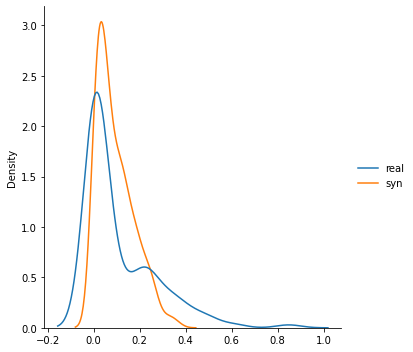

In [12]:
x_feat_inter = x_feat_inter.detach().cpu().numpy()
import pandas as pd
c = 15
a = pd.DataFrame(data={'real': x_feats[:, c], 'syn':x_feat_inter[:, c]})
sns.displot(a, kind='kde')

<AxesSubplot:xlabel='real', ylabel='count'>

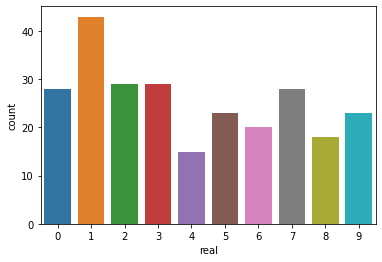

In [13]:
b = pd.DataFrame(data={'real': np.argmax(outputs, 1), 'syn': np.argmax(x_out.detach().cpu().numpy(), 1)})
sns.countplot(x='real', data=b)

<AxesSubplot:xlabel='syn', ylabel='count'>

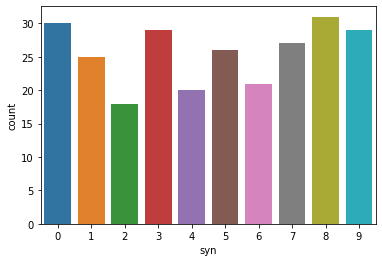

In [14]:
sns.countplot(x='syn', data=b)

In [62]:
G = datafree.models.generator.DCGAN_Generator_CIFAR10(nz=512, ngf=64, img_size=32, d=2, nc=3)
G = prepare_model(G)
ckpt_path = '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_reinter_testrelu.pth'
ckpt = torch.load(ckpt_path, map_location='cuda:{}'.format(gpu))
G.load_state_dict(ckpt['G_2'])
G.eval()

DCGAN_Generator_CIFAR10(
  (project): Sequential(
    (0): Flatten()
    (1): Linear(in_features=512, out_features=16384, bias=True)
  )
  (main): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Sigmoid()
  )
  (trans_convs): ModuleList(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
 

In [70]:
import torch.nn.functional as F
l = 2

if l == 0:
    func = normalizer
else:
    t_layer = getattr(teacher, 'layer{}'.format(l))
#     func = lambda x: F.relu(t_layer[-1].bn2(t_layer[-1].conv2(F.relu(t_layer[-1].bn1(x)))))
    func = lambda x: F.relu(t_layer[-1].bn2(x))
# z = torch.randn(256, 512).to(gpu)
layers = [teacher.bn1, teacher.layer1[-1].bn2, teacher.layer2[-1].bn2, teacher.layer3[-1].bn2]
stats = [(f.running_mean.data, f.running_var.data) for f in layers]
xs = G(z, l=l)
b,c,h,w = xs.size()
if l > 0:
    mu_l, var_l = stats[l]
#     dist = torch.distributions.Normal(mu_l, var_l)
#     real_sample = dist.sample((b*h*w,))
#     real_sample = real_sample.view([b, h, w, c]).permute(0,3,1,2)
    real_sample = mu_l.unsqueeze(0).unsqueeze(2).unsqueeze(3) + torch.sqrt(var_l).unsqueeze(0).unsqueeze(2).unsqueeze(3) * torch.randn_like(xs.detach())
#     print(stats[3])

# G samples at l-th layer
x_out, x_feat_inter_relu = teacher(func(xs), return_features=True, l=l)
x_feat_inter_relu = x_feat_inter_relu.detach().cpu().numpy()
# Real samples at l-th layer
if l > 0:
    x_out_r, x_feat_inter_relu_r = teacher(func(real_sample), return_features=True, l=l)
    x_feat_inter_relu_r = x_feat_inter_relu_r.detach().cpu().numpy()

In [71]:
# l1_div = F.l1_loss(x_out.detach().cpu(), torch.FloatTensor(outputs), reduction='none').sum(1).mean(0)
kl_div1 = F.kl_div(torch.log_softmax(x_out.detach().cpu(), 1), torch.softmax(torch.FloatTensor(outputs), 1), reduction='batchmean')
print('KL(T(x_G0) || T(x_real)) = {:.4f}'.format(kl_div1))
# print('L1(T(x_G0) || T(x_real)) = {:.4f}'.format(l1_div))

KL(T(x_G0) || T(x_real)) = 9.3812


In [72]:
print(mu_l, var_l)
nch = xs.size(1)
# print(torch.mean(real_sample, (0,2,3)), real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1, unbiased=False))
print(torch.mean(xs, (0,2,3)), xs.permute(1,0,2,3).contiguous().view([nch, -1]).var(1, unbiased=False))

tensor([-6.3950e-02, -2.5217e-02, -4.5562e-02, -5.1076e-02,  4.5238e-02,
        -2.1716e-02,  5.3187e-02, -7.4443e-02, -4.2352e-02,  3.7241e-02,
         1.7717e-02, -5.4798e-02, -1.1207e-03,  1.2826e-02,  1.9394e-02,
        -4.0911e-02, -5.4061e-02,  1.9924e-03, -8.4880e-02, -8.3783e-02,
        -4.5133e-02,  3.3152e-02, -1.0296e-01, -1.0681e-01,  4.3746e-02,
        -3.0993e-02, -4.7127e-02, -7.4871e-02, -3.0600e-02, -3.9238e-02,
         1.1951e-01, -3.5443e-02,  8.3788e-02,  6.3117e-02,  1.8221e-02,
        -4.2351e-02, -5.8926e-02, -6.1535e-02, -3.0871e-02, -5.8337e-02,
        -7.0574e-02,  1.2552e-02, -6.1406e-02,  7.5239e-03,  1.8665e-02,
        -5.5806e-02, -7.8460e-02, -6.3468e-02, -1.0984e-02, -3.9669e-02,
         4.5415e-02, -8.5921e-02,  5.8287e-02, -1.0118e-02,  3.0260e-02,
        -1.5095e-02, -2.3592e-02, -9.2657e-02, -1.2306e-01, -7.2667e-02,
        -6.7526e-02, -5.4116e-03, -7.3922e-05, -6.7469e-04, -8.7420e-04,
        -1.0056e-01,  6.0301e-02,  6.4452e-02,  2.7

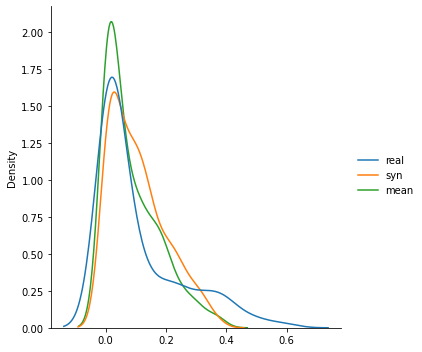

In [73]:
c = 16
# print(x_out[:, c])
# print(x_out_r[:, c])
# a = pd.DataFrame(data={'real': x_feats[:, c], 'syn':x_feat_inter[:, c], 'mean':x_feat_inter_relu[:, c]})
# print(x_feats.shape, x_feat_inter.shape, x_feat_inter_relu.shape, x_feat_inter_relu_r.shape)
# print(x_feat_inter_relu_r[:, c])
all_dict = {'real': x_feats[:, c], 'syn':x_feat_inter[:, c], 'mean':x_feat_inter_relu[:, c]}
# if l > 0:
#     all_dict['real_sample'] = x_feat_inter_relu_r[:, c]
a = pd.DataFrame(data=all_dict)
sns.displot(a, kind='kde')

<AxesSubplot:xlabel='real', ylabel='count'>

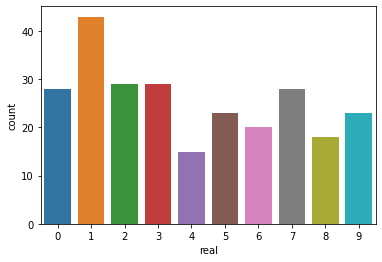

In [74]:
# print(outputs, x_out, x_out_r)
all_dict = {'real': np.argmax(outputs, 1), 'mean':x_out.argmax(1).detach().cpu().numpy()}
if l > 0:
    all_dict['real_sample'] = x_out_r.argmax(1).detach().cpu().numpy()
b = pd.DataFrame(data=all_dict)
sns.countplot(x='real', data=b)

<AxesSubplot:xlabel='mean', ylabel='count'>

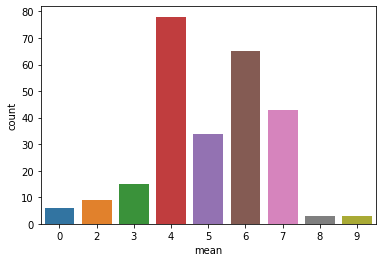

In [75]:
sns.countplot(x='mean', data=b)

In [77]:
loss_syn = get_losses(x_out.cpu(), torch.FloatTensor(x_feat_inter_relu))
print(loss_syn)
loss = get_losses(torch.FloatTensor(outputs), torch.FloatTensor(x_feats))
print(loss)

{'neg_ent': -1.7849887609481812, 't_conf': 0.14330041408538818, 'l_act': -0.1932353526353836}
{'neg_ent': -2.261824369430542, 't_conf': 0.0018974109552800655, 'l_act': -0.17903229594230652}


<AxesSubplot:xlabel='real_sample', ylabel='count'>

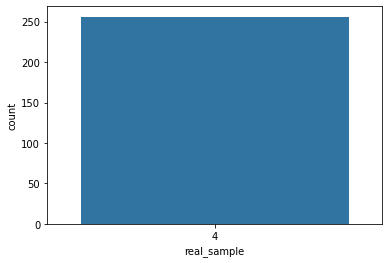

In [23]:
sns.countplot(x='real_sample', data=b)

In [25]:
_, (real_x, real_y) = enumerate(real_loader).__next__()
# print(real_x.shape, real_y.shape)
layer = getattr(teacher, 'layer{}'.format(l))
l_func = lambda x: teacher.layer2[:-1](F.relu(teacher.bn1(teacher.conv1(x))))
new_func = lambda x: teacher.layer2[-1].conv1(x)
new_func2 = lambda x, y: F.relu(layer[-1].bn2(layer[-1].conv2(F.relu(layer[-1].bn1(x))))+layer[-1].shortcut(y))
real_real_sample1 = l_func(real_x.to(gpu))
real_real_sample = new_func(real_real_sample1)
b,c,h,w = real_sample.size()
print(real_real_sample1.permute(1,0,2,3).contiguous().view([nch, -1]))
print(real_sample.permute(1,0,2,3).contiguous().view([nch, -1]))
out_x, out_feat = teacher(new_func2(real_real_sample, real_real_sample1), l=l, return_features=True)
all_dict['concat_real'] = out_x.argmax(1).detach().cpu().numpy()
# print(real_sample.shape)
b = pd.DataFrame(data=all_dict)
sns.countplot(x='concat_real', data=b)
# print(torch.mean(real_real_sample, (0,2,3)), real_real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1))
# print(torch.mean(func(real_sample), (0,2,3)), func(real_sample).permute(1,0,2,3).contiguous().view([nch, -1]).var(1, unbiased=False))
# print(mu_l, var_l)
# print(torch.mean(real_sample, (0,2,3)), real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1))
# print(real_sample)
# print('************')
# print(real_real_sample)
# print(torch.mean(real_sample, (2, 3)).var(0))
# print(torch.mean(real_real_sample, (2, 3)).var(0))
# dist = torch.distributions.Normal(mu_l, var_l)
# this_real_sample = dist.sample((b*h*w,))
# this_real_sample = this_real_sample.view([b, h, w, c]).permute(0,3,1,2)

# print(torch.mean(this_real_sample, (0,2,3)), this_real_sample.permute(1,0,2,3).contiguous().view([nch, -1]).var(1))

# print(mu_l - torch.mean(real_sample, (2, 3)).min(0)[0])
# print(mu_l - torch.mean(real_real_sample, (2,3)).min(0)[0])

tensor([[0.5922, 0.7885, 0.4750,  ..., 0.3057, 0.3211, 0.2452],
        [0.0000, 0.0000, 0.0000,  ..., 0.4029, 0.3721, 0.0774],
        [0.0000, 0.0000, 0.1842,  ..., 0.7598, 1.1055, 1.0439],
        ...,
        [1.2949, 1.7612, 1.5024,  ..., 0.3091, 0.2729, 0.0411],
        [0.1986, 0.1247, 0.0835,  ..., 0.1689, 0.1585, 0.0466],
        [0.0560, 0.1115, 0.1753,  ..., 0.2808, 0.3218, 0.4398]],
       device='cuda:2', grad_fn=<ViewBackward>)
tensor([[-0.6498, -0.3631, -0.0377,  ..., -0.6857, -0.9038, -0.5048],
        [-0.1964,  0.7827, -1.1429,  ..., -0.3629,  0.8135,  0.6026],
        [ 0.7798, -0.1770,  0.1008,  ...,  0.4154,  0.1110,  0.5587],
        ...,
        [ 1.6031,  0.7584, -0.3596,  ...,  0.7885,  1.6501, -1.0623],
        [-1.1224, -0.5100, -0.9289,  ...,  0.3350, -0.4403, -0.7031],
        [-0.2611, -0.4282,  1.4104,  ...,  0.2826,  0.9727,  0.4883]],
       device='cuda:2')


RuntimeError: running_mean should contain 128 elements not 64

In [26]:
# import pandas as pd
l = 1
layer = getattr(teacher, 'layer{}'.format(l))
G = datafree.models.generator.DCGAN_Generator_CIFAR10_more(nz=512, ngf=64, img_size=32, d=2, nc=3)
G = prepare_model(G)
ckpt_path = '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_bn1_shortcut.pth'
ckpt = torch.load(ckpt_path, map_location='cuda:{}'.format(gpu))
G.load_state_dict(ckpt['G_{}'.format(l)])
G.eval()

z = torch.randn(256, 512).to(gpu)
xs, real_x = G(z, l=l)
x_out, x_feat_inters = teacher(new_func2(xs, real_x), return_features=True, l=l)
x_feat_inters = x_feat_inters.detach().cpu().numpy()
print(x_feat_inters.shape)

c = 15
a = pd.DataFrame(data={'real': x_feats[:, c], 'mean':x_feat_inter_relu[:, c]})
sns.displot(a, kind='kde')

FileNotFoundError: [Errno 2] No such file or directory: '/data/lijingru/DataFree/checkpoints/datafree-probkd/cifar10-resnet34-resnet18--probkd_L2_bn1_shortcut.pth'

In [39]:
print(get_losses(x_out.cpu(), torch.FloatTensor(x_feat_inters)))
print(torch.mean(new_func(real_x), (2,3)), torch.mean(xs, (2,3)))

{'neg_ent': -2.2820231914520264, 't_conf': 0.3896195888519287, 'l_act': -0.17438821494579315}
tensor([[-0.0771,  0.2484, -0.2477,  ...,  0.1499,  0.0925,  0.1499],
        [-0.0529,  0.1834, -0.1757,  ...,  0.1203,  0.0693,  0.0949],
        [-0.0820,  0.2229, -0.2485,  ...,  0.1559,  0.0712,  0.1564],
        ...,
        [-0.0652,  0.1867, -0.1700,  ...,  0.0839,  0.0560,  0.0732],
        [-0.1253,  0.1327, -0.2509,  ...,  0.0498,  0.0075,  0.1808],
        [-0.0603,  0.1768, -0.0876,  ...,  0.0055,  0.0496, -0.0445]],
       device='cuda:2', grad_fn=<MeanBackward1>) tensor([[-0.0467,  0.2571, -0.2314,  ...,  0.1285,  0.0977,  0.1550],
        [-0.0355,  0.1898, -0.1674,  ...,  0.0916,  0.0705,  0.1047],
        [-0.0522,  0.2334, -0.2371,  ...,  0.1278,  0.0816,  0.1704],
        ...,
        [-0.0420,  0.1958, -0.1646,  ...,  0.0676,  0.0654,  0.0810],
        [-0.0993,  0.1369, -0.2444,  ...,  0.0258,  0.0139,  0.1925],
        [-0.0411,  0.1826, -0.0950,  ..., -0.0083,  0.0667, 

<AxesSubplot:xlabel='real', ylabel='count'>

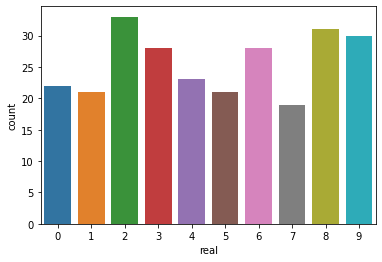

In [36]:
all_dict = {'real': np.argmax(outputs, 1), 'mean':x_out.argmax(1).detach().cpu().numpy()}
b = pd.DataFrame(data=all_dict)
sns.countplot(x='real', data=b)

<AxesSubplot:xlabel='mean', ylabel='count'>

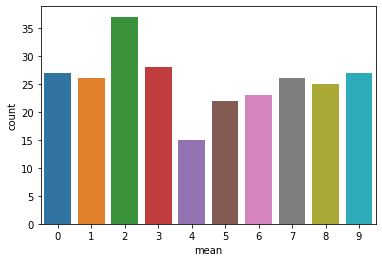

In [37]:
sns.countplot(x='mean', data=b)